In [1]:
import numpy as np
from pandas import read_pickle
import sklearn.cluster
import time
from wikiparse import pipeline_utils as utils

In [2]:
from pathlib import Path
from wikiparse import config

xml_filename = config.xml
scratch_folder = Path(config.folder)

In [3]:
import time
pipeline_start = time.time()

In [4]:
gdf = read_pickle(scratch_folder/'gdf.pkl')

Filter out all points outside the bounds of latitude and longitude (i.e., errors).

In [5]:
gdf['lon'] = gdf.geometry.map(lambda p: p.x)
gdf['lat'] = gdf.geometry.map(lambda p: p.y)
gdf.drop(gdf[gdf.lat > 90].index, inplace=True)
gdf.drop(gdf[gdf.lon > 180].index, inplace=True)
gdf.drop(gdf[gdf.lon < -180].index, inplace=True)
gdf.lat.min(), gdf.lat.max(), gdf.lon.min(), gdf.lon.max()

(-89.99755277777778, 89.3, -180.0, 180.0)

Use the KMeans algorithm to make clusters that we'll be able to label. I picked 193 because that's the number of member states in the UN (so, roughly a country-level cluster), 2,000 is a number vaguely chosen to be sub-state units like municipalities and territories, and 10,000 is vaguely chosen to represent the number of cities in the world.

In [6]:
partial_fit_size = min(len(gdf), 100_000)
batch_size = 100

for n_clusters in [193, 2000, 10_000]:
    start = time.time()
    # Convert DataFrame to matrix
    mat = gdf[['lat', 'lon']].values
    # Using sklearn
    km = sklearn.cluster.MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
    print("created model for", n_clusters)
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])

    # Format results as a DataFrame
    print(n_clusters, 'learning took', round((time.time()-start)/60, 1), 'minutes')
    
    start = time.time()
    labels = km.predict(mat)
    gdf['cluster_' + str(n_clusters)] = labels
    print('predicting took', round((time.time()-start)/60, 1), 'minutes')

created model for 193
193 learning took 0.1 minutes
predicting took 1.6 minutes
created model for 2000
2000 learning took 0.9 minutes
predicting took 12.1 minutes
created model for 10000
10000 learning took 4.7 minutes
predicting took 57.7 minutes


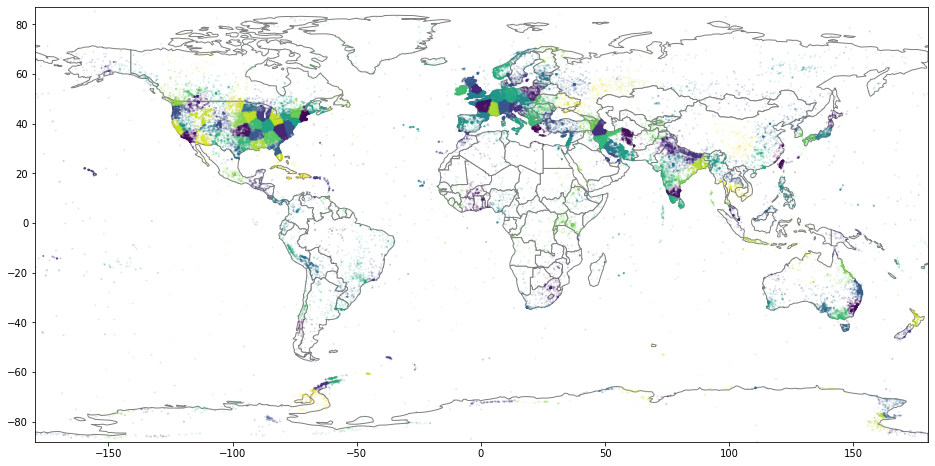

In [7]:
sample_gdf = gdf.sample(partial_fit_size)
utils.map_gdf(sample_gdf, c=sample_gdf.cluster_193, fname=scratch_folder/'clusters_193.png')

## Create continent-level clusters manually

Let's draw some rough lines around the continents so we can relabel those too.

In [8]:
def cluster_7(row, verbose=False):
    lat = row.lat
    lon = row.lon
    
    if lat < -55:
        if verbose: print("Antarctica")
        return 4
    if lon < -25:
        # N or S America
        if lat < 13:
            if verbose: print("South America")
            return 1
        if verbose: print("North America")
        return 0

    if lon > 35:
        if lat > 0:
            if lon < 60 and lat < 20:
                if verbose: print("African horn")
                return 6
            if verbose: print("Asia")
            return 2
        if lon < 70:
            if verbose: print("Africa south of equator")
            return 6
        if verbose: print("Oceania")
        return 3
    if lat > 35.8:
        if verbose: print("Europe")
        return 5
    if verbose: print("Africa")
    return 6

In [9]:
gdf['cluster_7'] = gdf.apply(cluster_7, axis=1)

In [10]:
gdf.sample(5)

,word,tf,article,df,tf_idf,geometry,lon,lat,cluster_193,cluster_2000,cluster_10000,cluster_7
4738480,impression,1,Mehairja,1233,0.00081103,POINT (51.45980 25.26910),51.459800,25.269100,42,1425,454,2
12154721,commuting,1,Chiswick Bridge,1015,0.000985222,POINT (-0.26972 51.47306),-0.269722,51.473056,91,348,7954,5
2321811,sarasota,1,South Bend International Airport,277,0.00361011,POINT (-86.31722 41.70833),-86.317222,41.708333,110,61,3320,0
5738852,romanized,1,"Kalik, Nowshahr",46122,2.16816e-05,POINT (51.65833 36.47444),51.658333,36.474444,136,335,6017,2
26576531,in,2,Atawallpa Much'u,603938,3.3116e-06,POINT (-71.05861 -15.20361),-71.058611,-15.203611,72,1610,3731,1


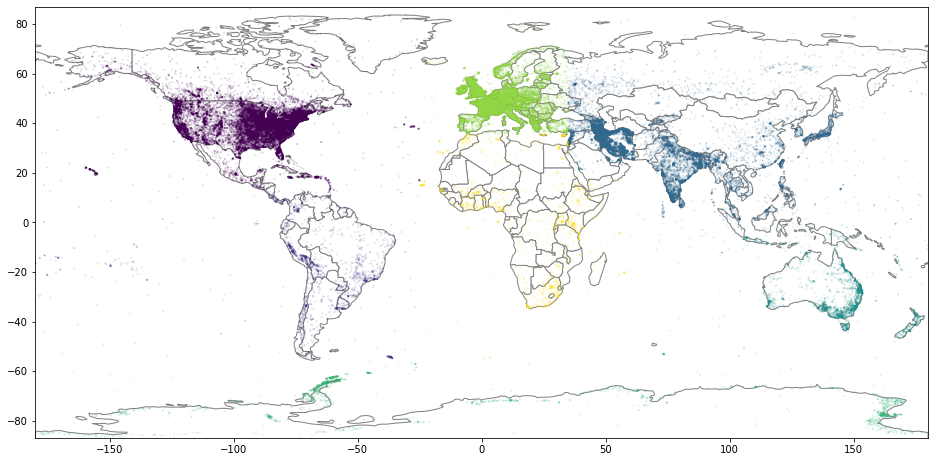

In [11]:
sample_gdf = gdf.sample(partial_fit_size)
utils.map_gdf(sample_gdf, c=sample_gdf.cluster_7, fname=scratch_folder/'clusters_7.png')

In [12]:
gdf.to_pickle(scratch_folder/'gdf_clusters.pkl')

In [13]:
took = time.time() - pipeline_start
if took < 60:
    print("pipeline took", round(took, 2), "seconds")
elif took < 3600:
    print("pipeline took", round(took/60, 2), "minutes")
else:
    print("pipeline took", round(took/60/60, 2), "hours")

pipeline took 2.94 hours
